In [1]:

import scipy.stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as tests
import pickle
from matplotlib.pyplot import figure


In [2]:
ERROR_RATE = 0.001
# filename = "/cs/labs/michall/roeizucker/HomeWork/comp_gen/hackton/output_STL003.pickle"
filename = "/cs/labs/michall/roeizucker/HomeWork/comp_gen/hackton/output_STL001.pickle"
# output_file = "~/www/output_STL03_sig.csv"
TEST_FILE = False
SIG_RATE = 0.05
WRITE_OUTPUT = False
SIZE = 1000
RANGE = 1000


In [3]:




def calculate_pval_for_snp_count(snp1_count, snp2_count,tested_perc,flip=True):
    pval = 0
    snp_sum = snp1_count + snp2_count
    tested = snp1_count
    if flip:
        if snp2_count < snp1_count:
            tested = snp2_count
    for i in range(tested):
        pval+=st.binom.pmf(i, snp_sum,tested_perc)
    return pval
    
def calculate_pval_list(snp1_list, snp2_list, tested_perc, flip=True):
    pvals = []
    for i in range(len(snp1_list)):
        pvals.append(calculate_pval_for_snp_count(int(snp1_list[i]),int(snp2_list[i]),tested_perc,flip))
    return pvals

print("done")

done


In [4]:
value_list = [['name','snp1','snp2']]
counter = 0
import pickle
if TEST_FILE:
    infile = open(filename,'rb')
    new_dict = pickle.load(infile)
    infile.close()
    for val in new_dict:
        if len(new_dict[val]) == 2 and new_dict[val][0] !=0 and new_dict[val][1] !=0:
            if new_dict[val][0] > new_dict[val][1]:
                value_list.append([val,new_dict[val][0],new_dict[val][1]])
            else:
                value_list.append([val,new_dict[val][1],new_dict[val][0]])
else:  
    for i in np.random.randint(RANGE, size=(SIZE, 2)):
        value_list.append(["Row" + str(counter),i[0],i[1]])
        counter+=1


data = np.array(value_list)
frame = pd.DataFrame(data=data[1:,0:],
#                   index=data[1:,0],
                  columns=data[0,0:])
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(frame)
print(len(frame))

print("done")

1000
done


In [5]:
frame["conf"] = 1- np.array(calculate_pval_list(list(frame["snp1"]),list(frame["snp2"]),ERROR_RATE))
conf_fixed = tests.multipletests(frame["conf"], alpha=SIG_RATE, method='fdr_bh', is_sorted=False, returnsorted=False)
frame["conf_fixed_sig"] = conf_fixed[0]
frame["conf_fixed_val"] = conf_fixed[1]

# keep only values that are significant 
frame = frame[frame["conf_fixed_sig"]]

frame["pvals"] = calculate_pval_list(list(frame["snp1"]),list(frame["snp2"]),0.5)
pval_fixed = tests.multipletests(frame["pvals"], alpha=SIG_RATE, method='fdr_bh', is_sorted=False, returnsorted=False)
frame["pval_fixed_sig"] = pval_fixed[0]
frame["pval_fixed_val"] = pval_fixed[1]

# keep only values that are significant 
frame = frame[frame["pval_fixed_sig"]]
print("done")

done


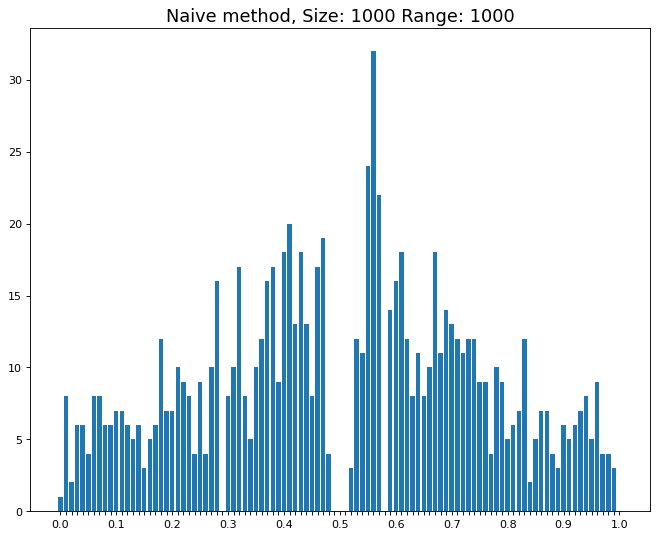

In [6]:
num_of_subgroups = 100
qvals = list(pd.to_numeric(frame["snp1"]) / (pd.to_numeric(frame["snp1"]) + pd.to_numeric(frame["snp2"])))
values = [0] * (num_of_subgroups + 1)
qvals = np.round(np.array(qvals), decimals=int(np.log10(num_of_subgroups)))
for i in qvals:
    values[int(i*num_of_subgroups)]+=1
names = []
for i in range(num_of_subgroups + 1):
    names.append(str(i/num_of_subgroups))


#     names.append(str(i/num_of_subgroups))
figure(figsize=(10, 8), dpi=80)

ax = plt.subplot(111)
bar_p = ax.bar(names,values)
xticks = ax.xaxis.get_major_ticks()
counter = 0
for tic in xticks:
    if counter%10 != 0:
        tic.label1.set_visible(False)
    counter+=1
plt.title("Naive method, Size: " + str(SIZE) + " Range: " + str(RANGE),fontsize=16)
plt.show()

In [7]:
import numpy as np
import pandas as pd
import scipy.stats as sp
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as tests
import pickle

new_frame = pd.DataFrame(data=data[1:,0:],
                  columns=data[0,0:])

p_vals = []
conf_vals = []
print("start calc pvals: ")
for index, row in new_frame.iterrows():
    val_1 = int(row['snp1'])
    val_2 = int(row['snp2'])
    reads_count = val_1+val_2
    #######################################
    #       bin(n, 0.5)     bin(n, else)  #
    #  SNP-1    n/2          row['snp1']  #
    #  SNP-2    n/2          row['snp2']  #
    #######################################
    if val_1 <= 5 or val_2<= 5:
        oddsratio, pvalue = \
            sp.fisher_exact([[reads_count / 2, val_1], [reads_count / 2,val_2]])
        p_vals.append(float(pvalue))

    else:
        oddsratio, pvalue = sp.chisquare([val_1, val_2], [reads_count/2, reads_count/2])
        p_vals.append(float(pvalue))

print("done with pvals")
new_frame["pvals"] = p_vals
new_frame["conf"] = 1- np.array(calculate_pval_list(list(new_frame["snp1"]),list(new_frame["snp2"]),ERROR_RATE))

conf_fixed = tests.multipletests(new_frame["conf"], alpha=SIG_RATE, method='fdr_bh', is_sorted=False, returnsorted=False)
new_frame["conf_fixed_sig"] = conf_fixed[0]
new_frame["conf_fixed_val"] = conf_fixed[1]

# keep only values that are significant
new_frame = new_frame[new_frame["conf_fixed_sig"]]

pval_fixed = tests.multipletests(new_frame["pvals"], alpha=SIG_RATE, method='fdr_bh', is_sorted=False, returnsorted=False)
new_frame["pval_fixed_sig"] = pval_fixed[0]
new_frame["pval_fixed_val"] = pval_fixed[1]

# keep only values that are significant
new_frame = new_frame[new_frame["pval_fixed_sig"]]
if WRITE_OUTPUT:
    new_frame["name"].str.split(pat=":",expand=True).to_csv(output_file)
print("done")


start calc pvals: 
done with pvals
done


done


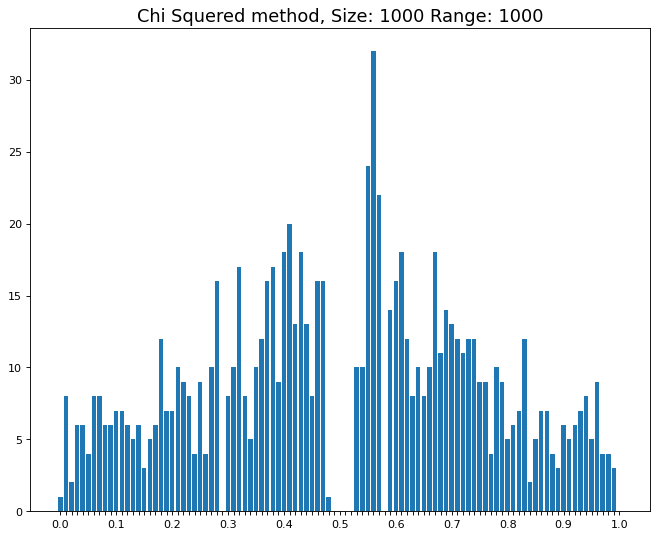

In [8]:
num_of_subgroups = 100
qvals = list(pd.to_numeric(new_frame["snp1"]) / (pd.to_numeric(new_frame["snp1"]) + pd.to_numeric(new_frame["snp2"])))
values = [0] * (num_of_subgroups + 1)
qvals = np.round(np.array(qvals), decimals=int(np.log10(num_of_subgroups)))
for i in qvals:
    values[int(i*num_of_subgroups)]+=1
names = []
for i in range(num_of_subgroups + 1):
    names.append(str(i/num_of_subgroups))
figure(figsize=(10, 8), dpi=80)

ax = plt.subplot(111)
bar_p = ax.bar(names,values)
xticks = ax.xaxis.get_major_ticks()
counter = 0
for tic in xticks:
    if counter%10 != 0:
        tic.label1.set_visible(False)
    counter+=1
# plt.xticks([])

plt.title("Chi Squered method, Size: " + str(SIZE) + " Range: " + str(RANGE),fontsize=16)
print("done")